In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.decoding as dec

In [171]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

In [172]:
%matplotlib notebook

In [173]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [174]:
C_value=1.0
test_split=0.2
cv_nfolds=5
chance_level = 1/8. if experiment=='gratings' else 0.5

In [175]:
analysis_type='by_ncells'
test_type='morph_single' #'morph_single'
class_name = 'morphlevel'
match_rfs = False
overlap_thr= 0.0 #[0, 0.25, 0.5]

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)
print(basedir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph_single


## Output dirs

In [177]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)) or match_rfs:
    curr_dst_dir = os.path.join(basedir, 'controls')
else:
    curr_dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00
dff-ROC__stimulus__overlap0.00__C1.00


## Load

In [178]:
iterdf, missing = dec.load_iterdf(meta, class_name,experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
print(iterdf['overlap_thr'].unique())

(Li) Found 9 paths
(Lm) Found 9 paths
(V1) Found 9 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths
[0.]


In [179]:
print(analysis_type, test_type)
if analysis_type=='by_fov':
    grouper = ['intact', 'visual_area', 'condition', 'datakey']
else:
    grouper = ['intact', 'visual_area', 'condition', 'iteration']
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)):
    grouper.append('overlap_thr')
# if test_type is not None:
#     grouper.append('novel')
if analysis_type=='by_fov':
    mean_df = dec.average_across_iterations_by_fov(iterdf,
                        analysis_type=analysis_type, test_type=test_type,
                                                  grouper=grouper)
else:
    mean_df = dec.average_within_iterations_by_ncells(iterdf,
                         analysis_type=analysis_type,
                         test_type=test_type, grouper=grouper) 
if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

by_ncells morph_single
['intact', 'visual_area', 'condition', 'iteration', 'n_cells', 'novel']
novel: [False  True]
conditions: ['data' 'shuffled']


In [180]:
max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
print(max_ncells)
n_iters = iterdf['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells]
xlabels = [1, 32, 96, max_ncells]

128


In [181]:
# Get unique datasets/match cell #s
if analysis_type=='by_fov':
    match_ncells=False
    all_counts = mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
    max_ncells = all_counts.groupby('visual_area')['n_cells'].max().min() \
                    if match_ncells \
                    else all_counts.groupby('visual_area')['n_cells'].max().max() 
    min_ncells = all_counts.groupby('visual_area')['n_cells'].min().max() \
                    if match_ncells else 10
    print(min_ncells, max_ncells)
    fov_filter_str = 'matchNcells' if match_ncells else 'allcells'
    passdf = mean_df[(mean_df['n_cells']>=min_ncells) 
                        & (mean_df['n_cells']<=max_ncells)].copy()
    counts = passdf[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
    # Drop repeat FOVs based on N fits
    u_dkeys = aggr.drop_repeats(counts, criterion='max', colname='n_cells')
    finaldf = pd.concat([g for (va, dk), g in passdf.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
    finaldf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()
else:
    finaldf = iterdf[iterdf['n_cells']<=max_ncells].copy()
    max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
    print(max_ncells)
passdf['noise_corrs'] = ['intact' if f else 'shuffled' for f in passdf['intact']]
finaldf['noise_corrs'] = ['intact' if f else 'shuffled' for f in finaldf['intact']]

128


In [184]:
cols = ['visual_area', 'intact'] 
    
index = ['visual_area']
mean_ = finaldf[finaldf['morphlevel'].isin([0, 106])]

if test_type=='morph_single':
    cols.append('train_transform')
    index.append('train_transform')
    
if analysis_type=='by_ncells':
    cols.append('n_cells')
    columns='n_cells'
else:
    columns=None
index.append('intact')

if test_type is not None:
    score_table = mean_[~(mean_.novel) & (mean_.condition=='data')]\
            .groupby(cols)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=index, columns=columns)
else:
    score_table = mean_[(mean_.condition=='data')]\
            .groupby(cols)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=index, columns=columns)
score_table

heldout_test_score                      \
n_cells                                           1         2         4     
visual_area train_transform intact                                          
Li          10.0            True             0.534461  0.549379  0.584985   
            20.0            True             0.525604  0.541048  0.558424   
            30.0            True             0.517193  0.525872  0.562977   
            40.0            True             0.523862  0.531386  0.552909   
            50.0            True             0.548716  0.567602  0.593879   
Lm          10.0            True             0.511000  0.504333  0.507000   
            20.0            True             0.523833  0.548167  0.571333   
            30.0            True             0.531000  0.543167  0.549000   
            40.0            True             0.536667  0.547167  0.561833   
            50.0            True             0.556167  0.601500  0.644833   
V1          10.0            True             0.513786  0.529738  0.532333   
            20.0            True             0.520095  0.533857  0.557667   
            30.0            True             0.545190  0.575524  0.595833   
            40.0            True             0.544238  0.582571  0.606500   
            50.0            True             0.566738  0.613333  0.645000   

                                                                            \
n_cells                                  8         16        32        64    
visual_area train_transform intact                                           
Li          10.0            True    0.610174  0.641500  0.690030  0.771477   
            20.0            True    0.589159  0.612455  0.643341  0.714356   
            30.0            True    0.575371  0.599197  0.625818  0.707712   
            40.0            True    0.564280  0.577917  0.601750  0.659705   
            50.0            True    0.627114  0.657720  0.693742  0.791477   
Lm          10.0            True    0.517833  0.533667  0.527000  0.559000   
            20.0            True    0.587000  0.597167  0.630667  0.689667   
            30.0            True    0.570167  0.602167  0.612167  0.670333   
            40.0            True    0.583333  0.611000  0.638000  0.702333   
            50.0            True    0.685667  0.728333  0.791333  0.889167   
V1          10.0            True    0.533167  0.554167  0.541000  0.568000   
            20.0            True    0.580667  0.598333  0.627500  0.693667   
            30.0            True    0.648833  0.688500  0.724667  0.824167   
            40.0            True    0.647167  0.696833  0.751167  0.835667   
            50.0            True    0.709500  0.742500  0.824333  0.917000   

                                                        
n_cells                                  96        128  
visual_area train_transform intact                      
Li          10.0            True    0.823788  0.855932  
            20.0            True    0.768811  0.797773  
            30.0            True    0.739955  0.772500  
            40.0            True    0.684265  0.718045  
            50.0            True    0.839606  0.883795  
Lm          10.0            True    0.554333  0.568333  
            20.0            True    0.739167  0.787667  
            30.0            True    0.732500  0.769833  
            40.0            True    0.749833  0.790333  
            50.0            True    0.944333  0.972333  
V1          10.0            True    0.595500  0.604833  
            20.0            True    0.739167  0.777167  
            30.0            True    0.887667  0.923167  
            40.0            True    0.897667  0.928000  
            50.0            True    0.956667  0.980500

In [185]:
metric = 'heldout_test_score'
%matplotlib notebook
if test_type is not None:
    plotd0 = finaldf[(finaldf['intact'])].copy()
    plotd = plotd0[plotd0['morphlevel']==0]\
                    .groupby(['visual_area', 'datakey', 'novel', 'condition'])\
                    .mean().reset_index()
    hue_column = 'novel' if test_type is not None else 'intact'
    hue_values = sorted(plotd[hue_column].unique())
    cond_colors = {hue_values[0]: [0.3]*3, hue_values[1]: [0.7]*3}    
    
    if analysis_type=='by_fov':
        fig, axn = pl.subplots(1, 2, figsize=(5.5,3), sharex=True, sharey=True)
        for ai, (cond, df_) in enumerate(plotd.groupby('condition')):
            title = 'true_targets' if cond=='data' else 'shuffled_targets'
            ai = 0 if cond=='data' else 1
            ax=axn[ai]; ax.set_title(title)
            sns.barplot(x='visual_area', y=metric, ax=ax, data=df_,
                       hue=hue_column, palette=cond_colors, ci='sd',
                       order=visual_areas)
            ax.legend_.remove()
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                 title=hue_column)
        pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
        ax.set_ylim([0, 1])

        sns.despine(trim=True)
        pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.3)
        figname = 'scores_avg_fov__%s' % aggr_id
        pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
        print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


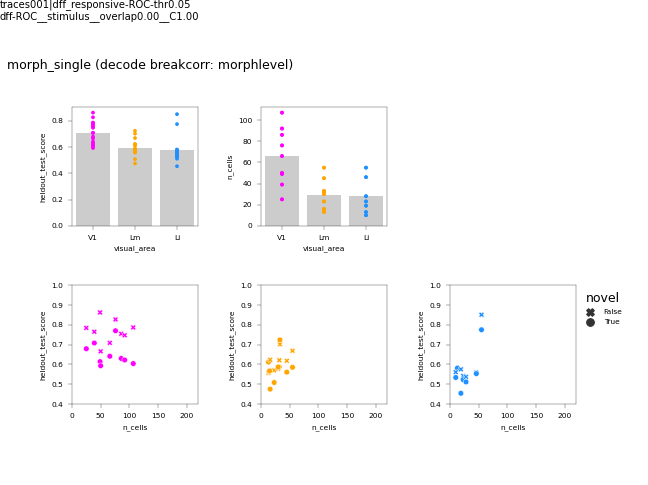

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 accuracy_vs_ncells_breakcorr


<IPython.core.display.Javascript object>


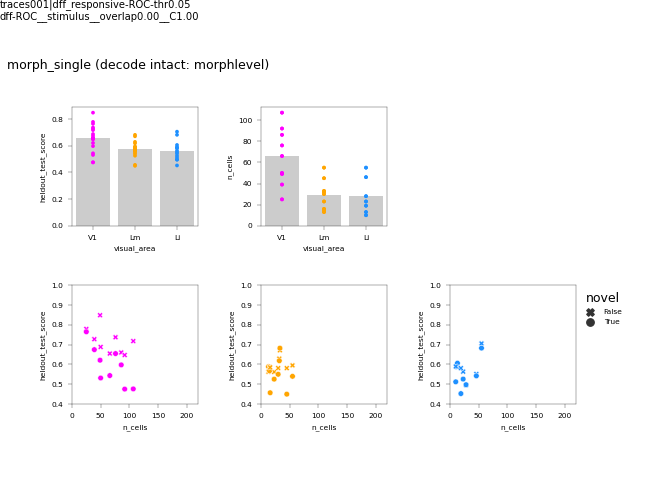

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 accuracy_vs_ncells_intact


In [163]:
%matplotlib notebook
if analysis_type=='by_fov':
    cond_colors = {'data': [0.3]*3, 'shuffled': [0.7]*3}    
    hue_column = 'novel'
    markers={True: 'o', False: 'X'}

    if test_type is None:
        maindf = passdf[passdf.condition=='data'].copy()
    else:
        maindf = passdf[(passdf.condition=='data') & (passdf.morphlevel==0)].copy()

    for is_intact, plotd0 in maindf.groupby(['intact']):
        corr_str = 'intact' if is_intact else 'breakcorr'
        # Mean across train/test transforms (if size single)
        plotd = plotd0.groupby(['visual_area', 'datakey', 'novel']).mean().reset_index()

        fig, axn = pl.subplots(2, 3, figsize=(8,6))
        for ai, metric in enumerate(['heldout_test_score', 'n_cells']):
            ax=axn[0, ai]
            sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax, 
                        color=[0.8]*3, ci=None, order=visual_areas)
            sns.stripplot(x='visual_area', y=metric, data=plotd, ax=ax,
                        order=visual_areas, size=3,
                        hue='visual_area', palette=area_colors, jitter=False)
            ax.legend_.remove()

        for va, vg in plotd.groupby('visual_area'):
            ax=axn[1, visual_areas.index(va)]
            sns.scatterplot(x='n_cells', y='heldout_test_score', data=vg,
                        ax=ax, color=area_colors[va], s=20, style=hue_column, 
                        markers=markers)
            ax.set_ylim([0.4, 1])
            ax.set_xlim([0, 220])
            ax.legend_.remove()
        axn.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                      title=hue_column)
        axn[0, 2].axis('off')
        # ax.legend_.remove()
        pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.8, wspace=0.5, hspace=0.5)
        pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
        fig.text(0.01, 0.87, '%s (decode %s: %s)' % (test_str, corr_str, class_name))

        figname = 'accuracy_vs_ncells_%s' % corr_str
        pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
        print(curr_dst_dir, figname)

In [164]:
passdf[(passdf.intact) & (passdf.visual_area=='Li') & ~(passdf.novel)
      & (passdf.condition=='data') & (passdf.morphlevel==0)].groupby('datakey').mean()

,intact,novel,train_transform,test_transform,morphlevel,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,p_chooseB,n_samples,n_trials,iteration,n_cells,overlap_thr
datakey,,,,,,,,,,,,,,,,,,
20190602_JC091_fov1,True,False,30.0,30.0,0,0.001234,0.000345,0.699160,1.000000,0.705733,1.0,4991.8716,0.286200,6.0000,59.6,249.5,55.0,0.0
20190606_JC091_fov1,True,False,30.0,30.0,0,0.001091,0.000361,0.574068,0.815573,0.586281,1.0,4889.1560,0.416562,6.6008,64.4,249.5,13.0,0.0
20190607_JC091_fov1,True,False,30.0,30.0,0,0.001129,0.000361,0.555347,0.938031,0.563400,1.0,4876.3760,0.441467,6.0000,60.0,249.5,23.0,0.0
20190609_JC099_fov1,True,False,30.0,30.0,0,0.001408,0.000337,0.495666,0.955215,0.495433,1.0,5064.5424,0.511133,6.0000,60.0,249.5,28.0,0.0
20190612_JC099_fov1,True,False,30.0,30.0,0,0.001383,0.000343,0.569124,0.908592,0.581100,1.0,5065.0980,0.416467,6.0000,60.0,249.5,19.0,0.0
20190614_JC091_fov1,True,False,30.0,30.0,0,0.001286,0.000340,0.545855,1.000000,0.551400,1.0,5054.1940,0.439933,6.0000,60.0,249.5,46.0,0.0
20191018_JC113_fov1,True,False,30.0,30.0,0,0.001725,0.000376,0.577926,0.708931,0.589496,1.0,5025.5016,0.407539,11.5020,114.0,249.5,10.0,0.0


<IPython.core.display.Javascript object>


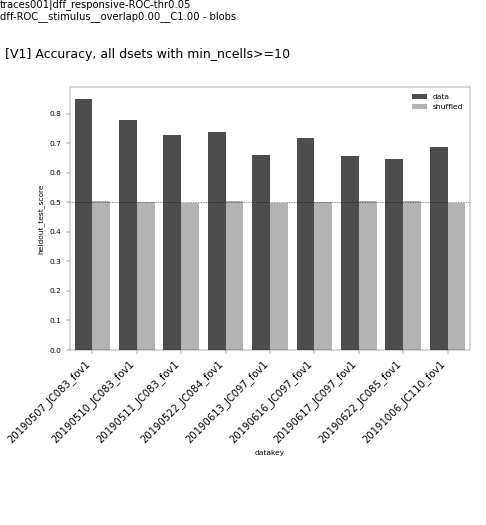

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 V1


<IPython.core.display.Javascript object>


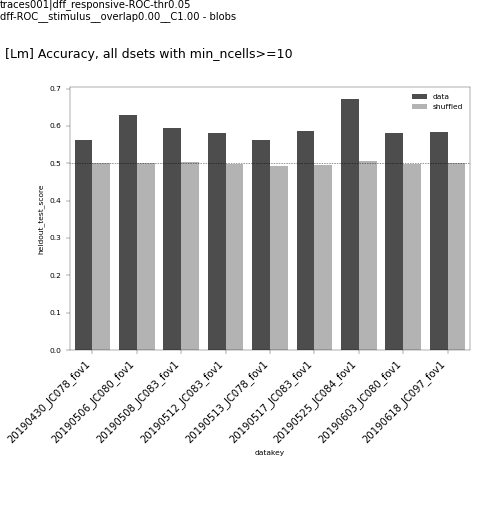

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 Lm


<IPython.core.display.Javascript object>


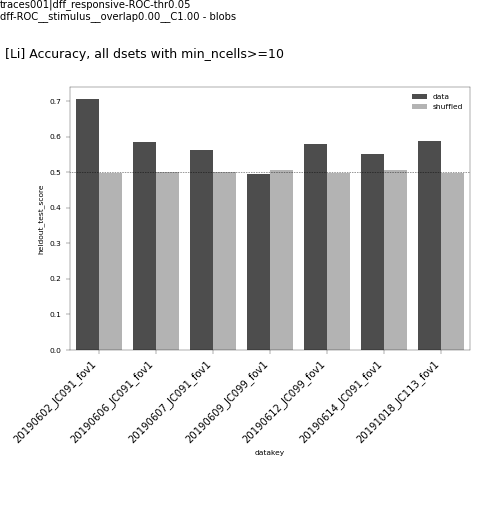

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 Li


In [165]:

if analysis_type=='by_fov':
    for va in visual_areas:
        currp = passdf[(passdf.intact) & (passdf.visual_area==va) & ~(passdf.novel)
                     & (passdf.morphlevel==0)].groupby(['datakey', 'condition'])\
                    .mean().reset_index()
        fig, ax = pl.subplots(figsize=(6,6.5))
        sns.barplot(x='datakey', y='heldout_test_score', data=currp, ax=ax,
                   hue='condition', palette=cond_colors)
        ax.legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)
        pl.subplots_adjust(left=0.13, bottom=0.4, right=0.87, top=0.85)
        ax.axhline(y=0.5, lw=0.5, ls=':', color='k')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        fig.text(0.01, 0.9, '[%s] Accuracy, all dsets with min_ncells>=%i' % (va, min_ncells))
        pplot.label_figure(fig, '%s\n%s - %s' % (data_id, aggr_id, experiment))
        pl.savefig(os.path.join(curr_dst_dir, 'acc_by_datakey_%s.svg' % va))
        print(curr_dst_dir, va)

In [166]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00'

<IPython.core.display.Javascript object>


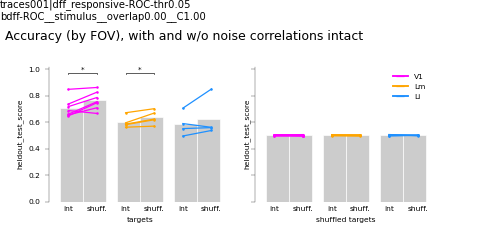

|    |   t_stat |   p_val | visual_area   | condition   |
|---:|---------:|--------:|:--------------|:------------|
|  0 |   -3.29  |   0.017 | V1            | data        |
|  1 |   -3.555 |   0.024 | Lm            | data        |
|  2 |   -1.107 |   0.349 | Li            | data        |
|  0 |    1.524 |   0.178 | V1            | shuffled    |
|  1 |    0.672 |   0.538 | Lm            | shuffled    |
|  2 |    0.39  |   0.722 | Li            | shuffled    |
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 paired_accuracy_break_noisecorrs_unique


In [169]:
%matplotlib notebook

metric='heldout_test_score'
if analysis_type=='by_fov':

    maindf = finaldf.copy()
    plotd = maindf[~(maindf.novel) & (maindf.morphlevel==0)]\
                .groupby(['visual_area', 'datakey', 'noise_corrs', 'condition']).mean()\
                .reset_index()

    s_=[]
    corr_colors={'intact': 'darkblue', 'shuffled': 'lightblue'}
    fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
    for ai, (cond, datad) in enumerate(plotd.groupby('condition')):
        ax=axn[ai]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1='intact', c2='shuffled', compare_var='noise_corrs',
                         return_stats=True, marker='.', size=2, edgecolor=['w']*3,
                         facecolor=[0.8]*3)
        pplot.annotate_sig_on_paired_plot(ax, datad, pstats, metric, lw=0.5,
                                     offset=0.1, h=0.01, fontsize=6)
        pstats['condition'] = cond
        s_.append(pstats)
statsdf = pd.concat(s_, axis=0)
print(statsdf.to_markdown())

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn):
    ax.set_xlabel('')
    xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    ax.set_xticklabels(xtick_labels)
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=visual_areas, marker='_')
axn[1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))

fig.text(0.01, 0.85, 'Accuracy (by FOV), with and w/o noise correlations intact')

figname = 'paired_accuracy_break_noisecorrs_unique'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [159]:
plotd[(plotd.condition=='shuffled') & (plotd.visual_area=='Li')][['datakey', 'noise_corrs','train_score', 'test_score',  'heldout_test_score']]

,datakey,noise_corrs,train_score,test_score,heldout_test_score
1,20190602_JC091_fov1,intact,0.999990,0.499840,0.496900
3,20190602_JC091_fov1,shuffled,1.000000,0.499578,0.500533
5,20190609_JC099_fov1,intact,0.960295,0.495718,0.506533
7,20190609_JC099_fov1,shuffled,0.972811,0.502947,0.496300
9,20190614_JC091_fov1,intact,0.999961,0.501553,0.505633
11,20190614_JC091_fov1,shuffled,0.999994,0.500747,0.503367
13,20191018_JC113_fov1,intact,0.661123,0.498604,0.497304
15,20191018_JC113_fov1,shuffled,0.663819,0.501848,0.501026


In [189]:
mean_df.columns

Index(['intact', 'visual_area', 'condition', 'iteration', 'n_cells', 'novel',
       'fit_time', 'score_time', 'test_score', 'train_score',
       'heldout_test_score', 'C', 'randi', 'p_chooseB', 'morphlevel',
       'n_samples', 'train_transform', 'test_transform', 'n_trials',
       'randi_cells', 'overlap_thr'],
      dtype='object')

(6840, 21)


<IPython.core.display.Javascript object>


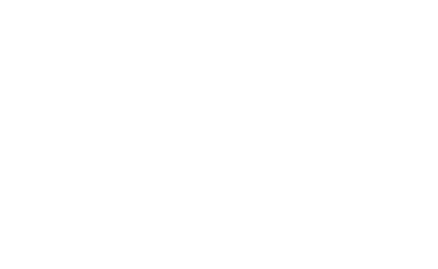

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 pchooseB_byFOVallcells


In [170]:
%matplotlib notebook
if analysis_type=='by_fov':
    plotdf = mean_df[(mean_df['morphlevel']!=-1) & ~(mean_df['novel'])]
    print(plotdf.shape)
    #cond_colors = {'data': 'k', 'shuffled': [0.7]*3}
    dashes={True:'', False:(1,1)}

    fig, axn = pl.subplots(1,3,figsize=(6.5,4), sharex=True, sharey=True)
    for va, df_ in plotdf.groupby(['visual_area']):
        ax=axn[visual_areas.index(va)]
        sns.lineplot(x='morphlevel', y='p_chooseB', hue='condition', style='intact',
                      data=df_, ax=ax, palette=None, ci=95, #scale=0.5,
                      err_style='bars',dashes=dashes,
                      err_kws={'lw': 0.5}, linewidth=1)
        n_fovs = len(df_['datakey'].unique())
        n_cells_avg = float(df_[['datakey','n_cells']].drop_duplicates()['n_cells'].mean())
        n_cells_sd = float(df_[['datakey','n_cells']].drop_duplicates()['n_cells'].std())
        ax.set_title('%s (k=%i sites)\nn=%.1f+/-%.1f cells)' \
                     % (va, n_fovs, n_cells_avg, n_cells_sd), loc='left', fontsize=8)
        ax.legend_.remove()
        ax.set_ylim([0.2,0.8])
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    pl.subplots_adjust(bottom=0.15, top=0.75)
    sns.despine(trim=True)

    fig.text(0.01, 0.85, 'Morph curves, avg by FOV (min/max=%i/%i - %s)' \
             % (min_ncells, max_ncells, fov_filter_str), fontsize=8)
    pl.subplots_adjust(left=0.1, bottom=0.2, right=0.8, top=0.7)

    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

    figname = 'pchooseB_byFOV%s' % fov_filter_str
    os.path.join(curr_dst_dir, '%s.svg' % figname)
    print(curr_dst_dir, figname)


<IPython.core.display.Javascript object>


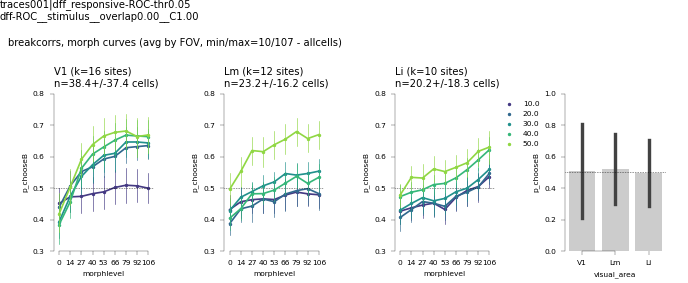

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 pchooseB_byFOVallcells_splittraining_breakcorrs


<IPython.core.display.Javascript object>


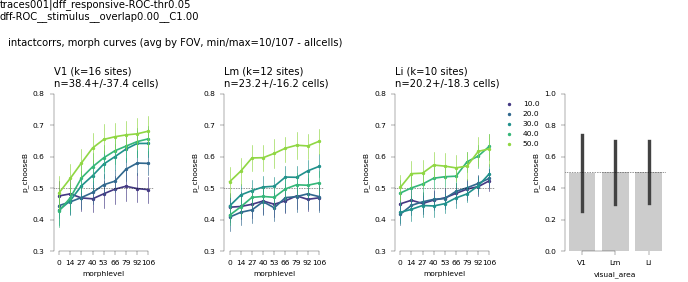

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__overlap0.00__C1.00 pchooseB_byFOVallcells_splittraining_intactcorrs


In [162]:
%matplotlib notebook
size_cmap = 'viridis'

for is_intact, plotdf in mean_df[mean_df.condition=='data'].groupby('intact'):
    corr_str = 'intactcorrs' if is_intact else 'breakcorrs'
    fig, axn = pl.subplots(1,4,figsize=(8.5,3.5), sharex=False, sharey=False)
    for va, df_ in plotdf[plotdf.morphlevel!=-1].groupby(['visual_area']):
        ax=axn[visual_areas.index(va)]
        sns.pointplot(x='morphlevel', y='p_chooseB', hue='train_transform', 
                      data=df_, ax=ax, palette=size_cmap, scale=0.5,
                      markers='.', errwidth=0.5, linewidth=0.5)
        n_fovs = len(df_['datakey'].unique())
        n_cells_avg = float(df_[['datakey','n_cells']].drop_duplicates()['n_cells'].mean())
        n_cells_sd = float(df_[['datakey','n_cells']].drop_duplicates()['n_cells'].std())
        ax.set_title('%s (k=%i sites)\nn=%.1f+/-%.1f cells)' \
                     % (va, n_fovs, n_cells_avg, n_cells_sd), loc='left', fontsize=8)
        ax.legend_.remove()
        ax.set_ylim([0.3,0.8])
        ax.axhline(y=0.5, linestyle=':', lw=0.5, c='k')
    axn[2].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    pl.subplots_adjust(bottom=0.15, top=0.75)
    sns.despine(trim=True)

    ax=axn[-1]
    sns.barplot(x='visual_area', y='p_chooseB', 
               data=plotdf[plotdf['morphlevel']==-1], ax=ax,
               order=visual_areas, color=[0.8]*3, ci='sd')
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, linestyle=':', lw=0.5, c='k')

    fig.text(0.01, 0.85, '%s, morph curves (avg by FOV, min/max=%i/%i - %s)' \
             % (corr_str, min_ncells, max_ncells, fov_filter_str), fontsize=8)
    pl.subplots_adjust(left=0.07, bottom=0.2, right=0.87, top=0.7, wspace=0.7)

    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

    figname = 'pchooseB_byFOV%s_splittraining_%s' % (fov_filter_str, corr_str)
    os.path.join(curr_dst_dir, '%s.svg' % figname)
    print(curr_dst_dir, figname)


# test_type='morph_single'

In [104]:
# plotd = mean_df[mean_df['n_cells']<=max_ncells].copy()
finaldf['novel_labels'] = None
finaldf.loc[finaldf['novel'], 'novel_labels'] = 'novel'
finaldf.loc[~finaldf['novel'], 'novel_labels'] = 'trained'
#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
novel_colors = {'trained': '', 'novel': (1,1)}

novel_colors = {'trained': [0.3]*3, 'novel': [0.7]*3}

<IPython.core.display.Javascript object>


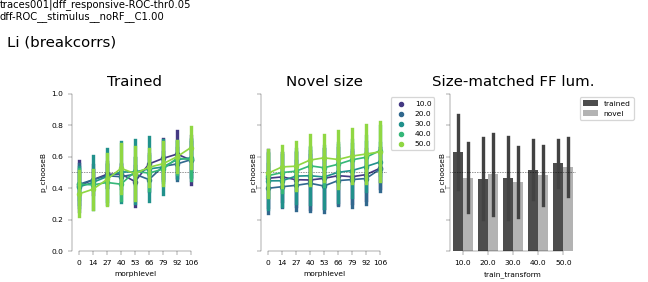

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 pchooseB_v_lum_Li_breakcorrs


<IPython.core.display.Javascript object>


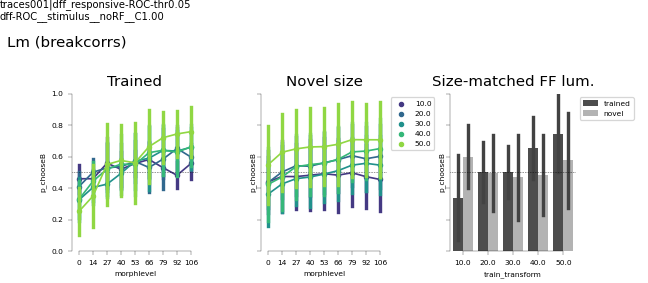

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 pchooseB_v_lum_Lm_breakcorrs


<IPython.core.display.Javascript object>


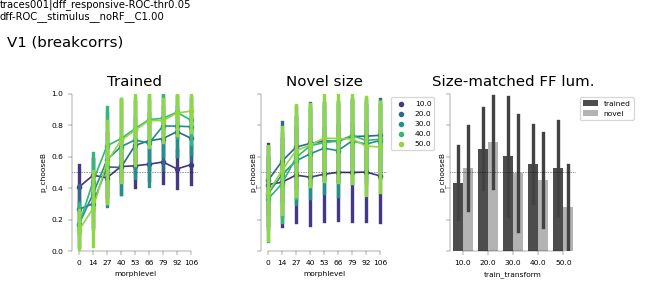

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 pchooseB_v_lum_V1_breakcorrs


<IPython.core.display.Javascript object>


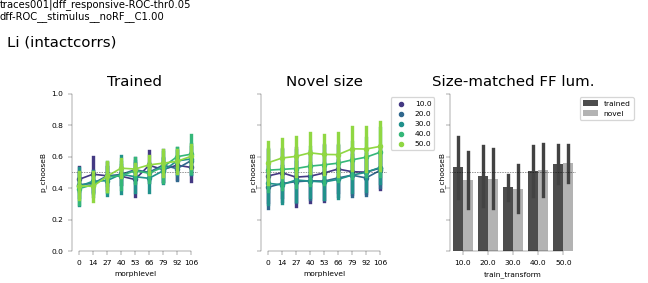

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 pchooseB_v_lum_Li_intactcorrs


<IPython.core.display.Javascript object>


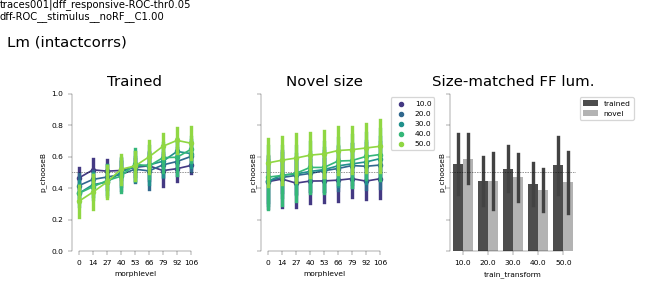

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 pchooseB_v_lum_Lm_intactcorrs


<IPython.core.display.Javascript object>


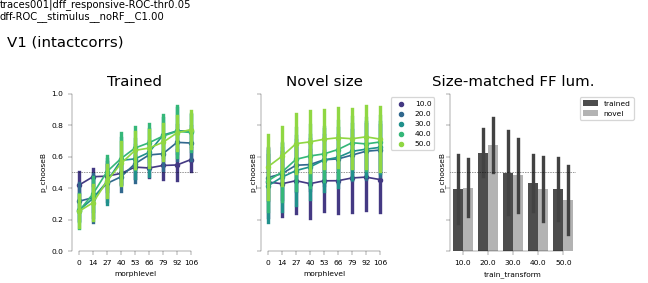

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 pchooseB_v_lum_V1_intactcorrs


In [47]:
%matplotlib notebook
cmap='viridis'

finaldf['novel_labels'] = None
finaldf.loc[finaldf['novel'], 'novel_labels'] = 'novel'
finaldf.loc[~finaldf['novel'], 'novel_labels'] = 'trained'
novel_colors = {'trained': [0.3]*3, 'novel': [0.7]*3}

plotd = finaldf[finaldf.intact].copy()
for is_intact, plotd in finaldf.groupby('intact'):
    corr_str = 'intactcorrs' if is_intact else 'breakcorrs'
    for va, res in plotd.groupby('visual_area'):
        plotd = res[res['morphlevel']!=-1].copy()
        fig, axn = pl.subplots(1,3, figsize=(8,3.5), sharey=True)

        ax=axn[0]
        ax.set_title('Trained')
        sns.pointplot(x='morphlevel', y='p_chooseB', ax=ax, 
                      hue='train_transform', palette=cmap,
                     data=plotd[(plotd['condition']=='data') & (~plotd['novel'])],
                     scale=0.5, ci='sd')
        ax.legend_.remove()

        ax=axn[1]
        ax.set_title('Novel size')
        sns.pointplot(x='morphlevel', y='p_chooseB', ax=ax, 
                      hue='train_transform',  palette=cmap,
                     data=plotd[(plotd['condition']=='data') & (plotd['novel'])],
                     scale=0.5, ci='sd')
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=6)

        ax=axn[2]
        ax.set_title('Size-matched FF lum.')
        plotd = res[res['morphlevel']==-1].copy()
        sns.barplot(x='train_transform', y='p_chooseB', ax=ax, 
                    hue='novel_labels', palette=novel_colors,
                  data=plotd[plotd['condition']=='data'], ci='sd')
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=6)
        for ax in axn.flat:
            ax.set_ylim([0, 1])
            ax.axhline(y=0.5, ls=':', c='k', lw=0.5)
        fig.text(0.01, 0.85, '%s (%s)' % (va, corr_str), fontsize=12)
        
        sns.despine(trim=True)
        pl.subplots_adjust(left=0.1, bottom=0.2, right=0.8, top=0.7, wspace=0.5)
        pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
        figname = 'pchooseB_v_lum_%s_%s' % (va, corr_str)
        pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
        print(curr_dst_dir, figname)

[10.0, 20.0, 30.0, 40.0, 50.0]


<IPython.core.display.Javascript object>


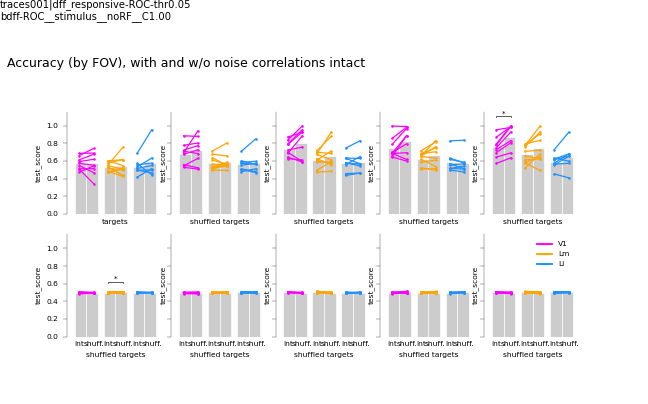

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 paired_accuracy_break_noisecorrs_splitTRAIN


In [48]:
%matplotlib notebook

maindf = finaldf.copy()

plotd = maindf[~(maindf.novel) & (maindf.morphlevel==0)]\
            .groupby(['visual_area', 'datakey', 'noise_corrs', \
                      'condition', 'train_transform']).mean().reset_index()
train_transforms = sorted(plotd['train_transform'].unique())
print(train_transforms)
metric='test_score'

fig, axn = pl.subplots(2,len(train_transforms), figsize=(8,5),
                       sharex=True, sharey=True)

for ti, (tcfg, traindf) in enumerate(plotd.groupby(['train_transform'])):

    for ai, (cond, datad) in enumerate(traindf.groupby('condition')):
        ax=axn[ai, ti]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1='intact', c2='shuffled', compare_var='noise_corrs',
                         return_stats=True, marker='.', size=2, edgecolor=['w']*3,
                         facecolor=[0.8]*3)
        pplot.annotate_sig_on_paired_plot(ax, datad, pstats, metric, lw=0.5,
                                     offset=0.1, h=0.01, fontsize=6)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn.flat):
    ax.set_xlabel('')
    #xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    ax.set_xticklabels(xtick_labels)
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=visual_areas, marker='_')
axn.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))

fig.text(0.01, 0.85, 'Accuracy (by FOV), with and w/o noise correlations intact')

figname = 'paired_accuracy_break_noisecorrs_splitTRAIN'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [195]:
for k, g in mean_df.groupby(['n_cells', 'visual_area', 'condition', 'intact', 
                 'train_transform', 'novel', 'morphlevel']):
    g

In [196]:
g

,intact,visual_area,condition,iteration,n_cells,novel,fit_time,score_time,test_score,train_score,...,C,randi,p_chooseB,morphlevel,n_samples,train_transform,test_transform,n_trials,randi_cells,overlap_thr
45017,True,V1,shuffled,0,128,True,0.045826,0.000426,0.823111,1.0,...,1.0,3844.4,0.663410,53.0,29.0,30.0,30.0,29.0,7948.0,0.0
45035,True,V1,shuffled,1,128,True,0.000922,0.000366,0.790667,1.0,...,1.0,5935.2,0.500575,53.0,29.0,30.0,30.0,29.0,9657.0,0.0
45053,True,V1,shuffled,2,128,True,0.000835,0.000354,0.840000,1.0,...,1.0,3744.4,0.396169,53.0,29.0,30.0,30.0,29.0,6999.0,0.0
45071,True,V1,shuffled,3,128,True,0.000826,0.000347,0.885778,1.0,...,1.0,4564.8,0.513985,53.0,29.0,30.0,30.0,29.0,2099.0,0.0
45089,True,V1,shuffled,4,128,True,0.000814,0.000345,0.839556,1.0,...,1.0,5740.0,0.522605,53.0,29.0,30.0,30.0,29.0,5932.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53927,True,V1,shuffled,495,128,True,0.000807,0.000343,0.818667,1.0,...,1.0,3948.4,0.501724,53.0,29.0,30.0,30.0,29.0,6467.0,0.0
53945,True,V1,shuffled,496,128,True,0.000811,0.000344,0.805778,1.0,...,1.0,4488.0,0.517241,53.0,29.0,30.0,30.0,29.0,4772.0,0.0
53963,True,V1,shuffled,497,128,True,0.000810,0.000343,0.817333,1.0,...,1.0,3522.0,0.510345,53.0,29.0,30.0,30.0,29.0,6515.0,0.0
53981,True,V1,shuffled,498,128,True,0.000814,0.000345,0.882222,1.0,...,1.0,2757.0,0.517050,53.0,29.0,30.0,30.0,29.0,7243.0,0.0


# Example FOV

In [513]:
print(experiment)
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

gratings


In [10]:
# dk = '20190616_JC097_fov1'
# va = 'V1'
print(experiment)
sdf = aggr.get_master_sdf(experiment)

blobs


In [11]:


class_name='morphlevel' if experiment=='blobs' else 'ori'
if experiment=='gratings':
    variation_name = None
else:
    variation_name = None if test_type is None else 'size'
variation_values=None
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)
class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
clf_params={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

morphlevel 0 106


In [514]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [523]:
import copy
inargs = copy.copy(clf_params)


In [524]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [525]:
inum=3
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, **inargs)
i_df

... 3 - selecting


,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
3,0.472028,0.010411,0.255849,0.835691,0.289775,0.094974,0.418057,0.304688,1.0,606,data,93,1280,3
3,1.024186,0.010827,0.127958,0.648679,0.079508,-0.012930,0.114706,0.136719,1.0,606,shuffled,93,1280,3


In [509]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [533]:
res[['train_score', 'test_score', 'heldout_test_score', 'condition']].groupby(['condition']).describe()

train_score                                                    \
                count      mean       std       min       25%       50%   
condition                                                                 
data             10.0  0.840819  0.010435  0.827876  0.831909  0.839475   
shuffled         10.0  0.616845  0.010824  0.597910  0.614318  0.617431   

                              test_score            ...                      \
                75%       max      count      mean  ...       75%       max   
condition                                           ...                       
data       0.848389  0.859373       10.0  0.258572  ...  0.265328  0.275371   
shuffled   0.621334  0.634036       10.0  0.124227  ...  0.133576  0.138661   

          heldout_test_score                                                   \
                       count      mean       std      min       25%       50%   
condition                                                                       
data                    10.0  0.273828  0.030002  0.21875  0.254883  0.275391   
shuffled                10.0  0.129688  0.023567  0.09375  0.110352  0.136719   

                               
                75%       max  
condition                      
data       0.294922  0.320312  
shuffled   0.146484  0.160156  

[2 rows x 24 columns]

In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [376]:
# inum =2
# res = dec.train_test_size

In [436]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_subset(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


In [437]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.006387,0.000969,0.706091,1.0,0.040743,0.045418,0.058780,0.641509,1.0,7228,data,10_20_30_40,10_20_30_40,264,False,2,221
1,0.008795,0.001038,0.492802,1.0,0.022424,0.019121,0.032351,0.396226,1.0,7228,shuffled,10_20_30_40,10_20_30_40,264,False,2,221
2,0.006387,0.000969,0.706091,1.0,0.084611,0.119522,0.122068,0.686567,1.0,7228,data,10_20_30_40,50.0,67,True,2,221
3,0.006277,0.000910,0.663677,1.0,0.102707,0.137532,0.148175,0.716981,1.0,9823,data,10_20_30_50,10_20_30_50,264,False,2,221
4,0.007357,0.000959,0.502436,1.0,0.000147,-0.014046,0.000213,0.490566,1.0,9823,shuffled,10_20_30_50,10_20_30_50,264,False,2,221
5,0.006277,0.000910,0.663677,1.0,0.111929,0.152264,0.161479,0.731343,1.0,9823,data,10_20_30_50,40.0,67,True,2,221
6,0.005600,0.000857,0.682835,1.0,0.001548,-0.011960,0.002234,0.528302,1.0,5767,data,10_20_40_50,10_20_40_50,264,False,2,221
7,0.008921,0.001029,0.426135,1.0,0.004288,-0.008155,0.006187,0.547170,1.0,5767,shuffled,10_20_40_50,10_20_40_50,264,False,2,221
8,0.005600,0.000857,0.682835,1.0,0.046699,0.058313,0.067372,0.647059,1.0,5767,data,10_20_40_50,30.0,68,True,2,221
9,0.005312,0.000805,0.668217,1.0,0.052276,0.062297,0.075418,0.660377,1.0,1688,data,10_30_40_50,10_30_40_50,264,False,2,221


In [430]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [431]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_single(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


1.0
(4,)
1.0
(4,)
0.610909090909091
(4,)
0.0020420074462890623
(4,)
0.0006659507751464843
(4,)
6564
(4,)
10.0
(4,)
1.0
(4,)
1.0
(4,)
0.7654545454545454
(4,)
0.0014920711517333984
(4,)
0.0004935741424560546
(4,)
5899
(4,)
20.0
(4,)
1.0
(4,)
1.0
(4,)
0.7781818181818183
(4,)
0.0015712738037109374
(4,)
0.0005093574523925781
(4,)
6167
(4,)
30.0
(4,)
1.0
(4,)
1.0
(4,)
0.730909090909091
(4,)
0.0014906883239746093
(4,)
0.0005062580108642578
(4,)
1901
(4,)
40.0
(4,)
1.0
(4,)
1.0
(4,)
0.6581818181818182
(4,)
0.0014026165008544922
(4,)
0.00045900344848632814
(4,)
1571
(4,)
50.0
(4,)


In [434]:
res.groupby(['condition', 'novel']).mean()

fit_time  score_time  test_score  train_score  heldout_MI  \
condition novel                                                              
data      False  0.001600    0.000527    0.708727          1.0    0.311854   
          True   0.001600    0.000527    0.708727          1.0    0.066433   
shuffled  False  0.001566    0.000512    0.535636          1.0    0.044120   

                 heldout_aMI  heldout_log2MI  heldout_test_score    C   randi  \
condition novel                                                                 
data      False     0.418541        0.449911            0.828571  1.0  4420.4   
          True      0.087560        0.095842            0.615979  1.0  4420.4   
shuffled  False     0.004287        0.063652            0.385714  1.0  4420.4   

                 train_transform  test_transform  n_trials  iteration  n_cells  
condition novel                                                                 
data      False             30.0            30.0      66.8        2.0    221.0  
          True              30.0            30.0      67.4        2.0    221.0  
shuffled  False             30.0            30.0      66.8        2.0    221.0

In [435]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.002042,0.000666,0.610909,1.0,0.051757,0.014048,0.074670,0.642857,1.0,6564,data,10.0,10.0,68,False,2,221
1,0.001622,0.000542,0.536364,1.0,0.010239,-0.045851,0.014772,0.428571,1.0,6564,shuffled,10.0,10.0,68,False,2,221
2,0.002042,0.000666,0.610909,1.0,0.001906,-0.009494,0.002749,0.522388,1.0,6564,data,10.0,20.0,67,True,2,221
3,0.002042,0.000666,0.610909,1.0,0.004072,-0.005124,0.005874,0.455882,1.0,6564,data,10.0,30.0,68,True,2,221
4,0.002042,0.000666,0.610909,1.0,0.015436,0.012156,0.022270,0.417910,1.0,6564,data,10.0,40.0,67,True,2,221
5,0.002042,0.000666,0.610909,1.0,0.011254,0.005980,0.016236,0.447761,1.0,6564,data,10.0,50.0,67,True,2,221
6,0.001492,0.000494,0.765455,1.0,0.178715,0.213523,0.257831,0.785714,1.0,5899,data,20.0,20.0,66,False,2,221
7,0.001532,0.000509,0.536364,1.0,0.094878,0.083770,0.136879,0.285714,1.0,5899,shuffled,20.0,20.0,66,False,2,221
8,0.001492,0.000494,0.765455,1.0,0.000000,-0.010967,0.000000,0.500000,1.0,5899,data,20.0,10.0,68,True,2,221
9,0.001492,0.000494,0.765455,1.0,0.148230,0.205488,0.213851,0.764706,1.0,5899,data,20.0,30.0,68,True,2,221


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


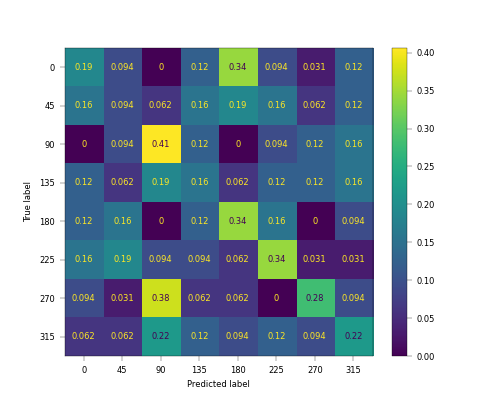

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")